In this notebook, we take check how transmission looks like if we use two same patterns in one cell.

This should give the same transmission results as using just one copy of the pattern. More bands will show up if we perturb the pattern.

In [1]:
from rcwa4d import *
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

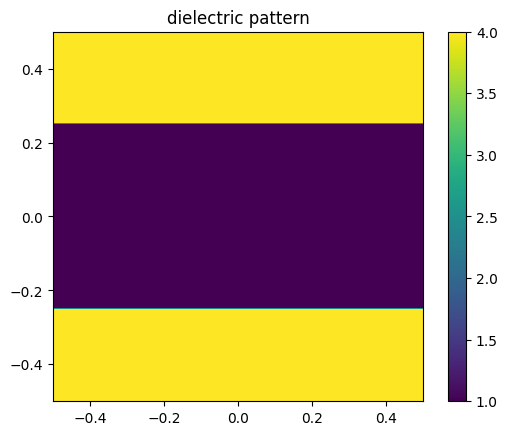

In [2]:
### some params
DEG = np.pi/180
Ny=Nx=1000 ### resolution for dielectric pattern
eps = np.ones([Ny,Nx])*4 ### uniform dielectric slab
radius = 0.25
thickness = 0.2
xs,ys = np.linspace(-0.5,0.5,Nx), np.linspace(-0.5,0.5,Ny)
xs,ys = np.meshgrid(xs,ys)
eps[ys**2 < radius**2] = 1 ### air holes in dielectric slab
plt.imshow(eps,extent=[-0.5,0.5,-0.5,0.5]); 
plt.colorbar(); plt.title('dielectric pattern'); plt.show()
### frequencies to scan through:
freqs = np.linspace(0.51,0.99,101)
thetas = np.linspace(1e-4,89,101) * DEG
inds = range(1,6)

### verifying convention
i.e. we are using exp(-ikx) convention with phase decreasing during propagation

In [3]:
ind = 1
freq = 0.7
gaps = [0,0.01]

In [4]:
obj = rcwa([np.ones([100,100])], [0.01], [1], twist=0, N=0, M=ind, verbose=0)
obj.set_freq_k(0.7, (0, 0))
obj.get_RT(0,1)
print(obj.transmitted)

[[0.        +0.j        ]
 [0.99903293-0.04396812j]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]]


In [5]:
for gap in gaps:
    obj = rcwa([eps,None,eps], [thickness,gap,thickness], [1,1,2], gap_layer_indices=[1], twist=0.1, N=0, M=ind, verbose=0)
    obj.set_freq_k(freq, (0, 0))
    (r,t), (reflected,transmitted) = obj.get_RT(0,1)
    print(np.angle(transmitted[0]))

2.568783938417757
2.535200327700019


## verifying equivalence
adding air layer and changing z_offset should be equivalent
?! Seems one of them has sign problem

In [11]:
obj = rcwa([2*np.ones([100,100]),np.ones([100,100])], [0.2,0.1], [1,1], twist=0, N=0, M=ind, verbose=0)
obj.set_freq_k(0.7, (0, 0))
obj.get_RT(0,1,storing_intermediate_Smats=True)
obj.get_RT_field()

(array([ 0.        +0.j        , -0.30244835-0.09664943j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.09664943-0.30244835j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ]),
 array([ 0.        +0.j        , -0.12341686-0.9401873j ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.9401873 -0.12341686j,
         0.        +0.j        ,  0.        +0.j        ,
         0. 

In [12]:
obj = rcwa([2*np.ones([100,100]),np.ones([100,100])], [0.2,0.2], [1,1], twist=0, N=0, M=ind, verbose=0)
obj.set_freq_k(0.7, (0, 0))
obj.get_RT(0,1,storing_intermediate_Smats=True)
obj.get_internal_field(which_layers=[1],offsets=[0.1])

[array([ 0.        +0.j        , -0.12341686-0.9401873j ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        , -0.9401873 +0.12341686j,
         0.        +0.j        ,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ])]

### for gaussian incidence field

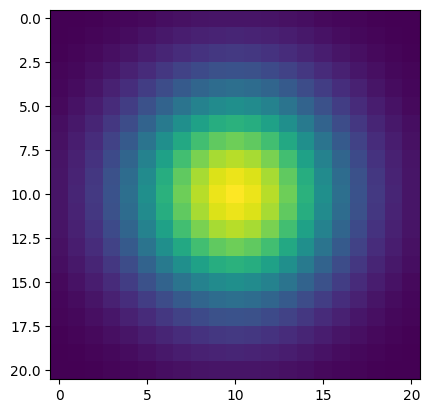

In [19]:
freq = 1.4
ks = np.linspace(-0.2,0.2,21)
kxs, kys = np.meshgrid(ks,ks)
kincs = np.vstack([kxs.flatten(),kys.flatten()]).T
amps = np.exp((-kxs**2-kys**2)/0.12**2)
plt.imshow(amps)

441it [00:02, 173.99it/s]


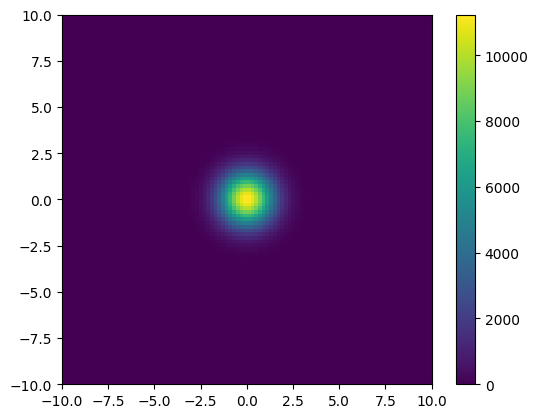

441it [00:00, 546.48it/s]


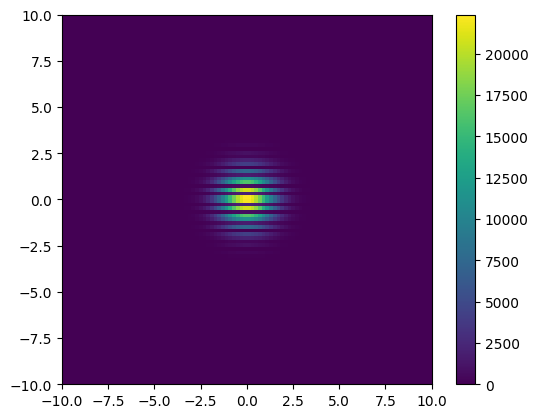

In [23]:
### trivial air propagation, vs propagation through grating
obj1 = rcwa([np.ones([100,100])], [0], [1], twist=0, N=0, M=ind, verbose=0)
obj2 = rcwa([eps,None,eps], [thickness,0,thickness], [1,1,2], gap_layer_indices=[1], twist=0, N=0, M=ind, verbose=0)
for obj in [obj1, obj2]:
    tmp = SummedRCWA(obj, freq, kincs, amps)
    tmp.total_RT()
    fields = tmp.get_field(len(obj.layer_thicknesses),5,real_space=True)
    ex,ey,ez,hx,hy,hz = fields
    plt.imshow(np.abs(ex)**2+np.abs(ey)**2,extent=[tmp.x_min,tmp.x_max,tmp.y_min,tmp.y_max])
    plt.colorbar()
    plt.show()